In [ ]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
train_data_dir = 'train'
test_data_dir = 'test'

In [ ]:
def load_dataset(data_dir):
    images = []
    labels = []

    images_dir = os.path.join(data_dir, 'images')  
    labels_dir = os.path.join(data_dir, 'labels')  

    for filename in os.listdir(images_dir):
        if filename.endswith('.jpeg'):
            img_path = os.path.join(images_dir, filename)
            label_filename = filename.replace('.jpeg', '.txt')  
            label_path = os.path.join(labels_dir, label_filename) 

            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label = int(f.read().strip())  
                    images.append(img_path)
                    labels.append(label)

    return images, labels

In [ ]:

train_images, train_labels = load_dataset(train_data_dir)
test_images, test_labels = load_dataset(test_data_dir)

In [ ]:
print(f"Number of train images: {len(train_images)}")
print(f"Number of train labels: {len(train_labels)}")
print(f"Number of test images: {len(test_images)}")
print(f"Number of test labels: {len(test_labels)}")

Number of train images: 2394
Number of train labels: 2394
Number of test images: 458
Number of test labels: 458


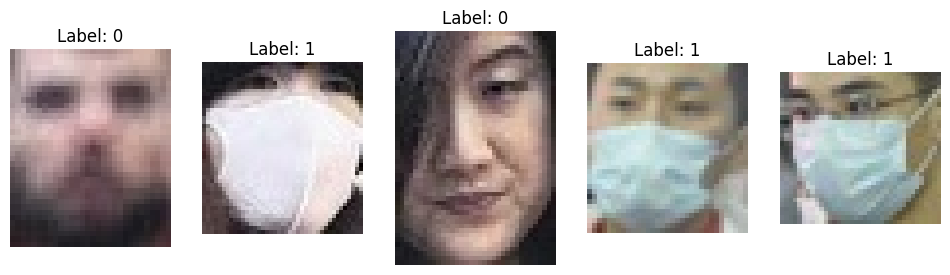

In [ ]:
plt.figure(figsize=(12, 8))
num_samples = 5  

for i in range(num_samples):
    image_path = train_images[i]
    label = train_labels[i]

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

In [ ]:
class FaceCoverDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)  # Load image using OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        if self.transform:
            image = self.transform(image)
        return image, label

# Define image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create training and testing datasets
train_dataset = FaceCoverDataset(train_images, train_labels, transform=transform)
test_dataset = FaceCoverDataset(test_images, test_labels, transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
class FaceCoverCNN(nn.Module):
    def __init__(self):
        super(FaceCoverCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 classes: wearing, not wearing, improper wearing

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x










In [ ]:
model = FaceCoverCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [ ]:
model.eval()
with torch.no_grad():
    all_predictions = []
    all_labels = []
    for images, labels in test_loader:
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1).tolist()
        all_predictions.extend(predictions)
        all_labels.extend(labels.tolist())

In [ ]:
accuracy = accuracy_score(all_labels, all_predictions)
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.9432314410480349
Confusion Matrix:
 [[ 47   4   0]
 [  5 378   5]
 [  1  11   7]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


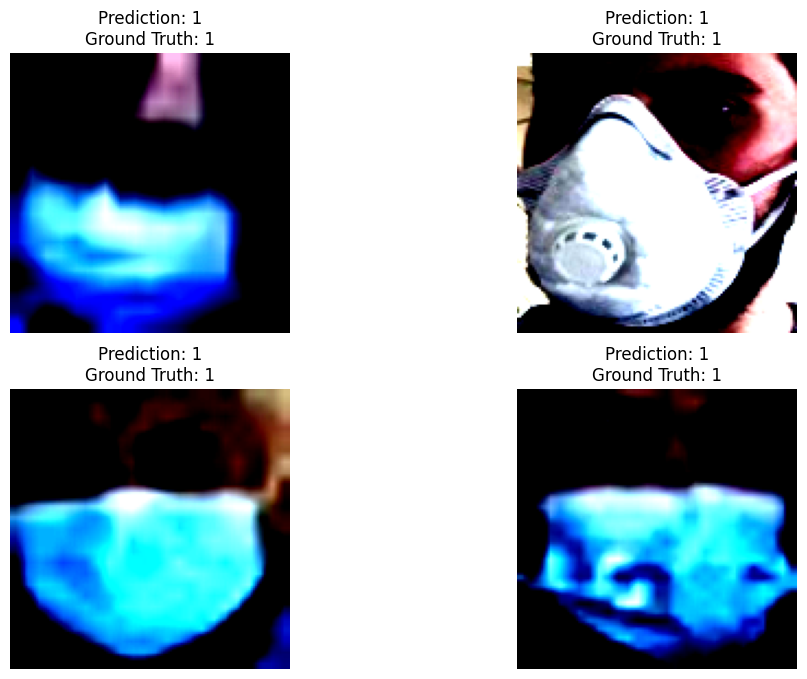

In [ ]:
def MaskDetection(path_to_testset, model_type):
    np.random.seed(42)
    random_indices = np.random.choice(len(test_dataset), size=4, replace=False)
    images = [test_dataset[i][0] for i in random_indices]
    labels = [test_dataset[i][1] for i in random_indices]

    # Display images with predictions
    plt.figure(figsize=(12, 8))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(f"Prediction: {all_predictions[random_indices[i]]}\nGround Truth: {labels[i]}")
        plt.axis('off')
    plt.show()

# Example usage:
MaskDetection(test_data_dir, 'CNN')


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from skimage.feature import hog
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pickle

In [ ]:
import cv2
from skimage.feature import hog
from skimage.transform import resize
from sklearn.base import BaseEstimator, TransformerMixin

class HOGTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(3, 3)):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        hog_features = []
        for image in X:
            img = cv2.imread(image)
            gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            resized_image = resize(gray_image, (48, 48))  # Resize to at least 48x48 pixels

            hog_image = hog(resized_image, orientations=self.orientations,
                            pixels_per_cell=self.pixels_per_cell,
                            cells_per_block=self.cells_per_block,
                            visualize=False)

            hog_features.append(hog_image)

        return np.array(hog_features)


In [ ]:
# Pipeline for HOG + SVM model
hog_svm_model = Pipeline([
    ('hog', HOGTransformer()),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=1.0))
])

# Train the HOG + SVM model
hog_svm_model.fit(train_images, train_labels)


Pipeline(steps=[('hog', HOGTransformer()), ('scaler', StandardScaler()),
                ('svm', SVC(kernel='linear'))])

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier


hog_mlp_model = Pipeline([
    ('hog', HOGTransformer()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),  # Adjust n_components based on valid range
    ('mlp', MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500))
])

# Train the HOG + MLP model
hog_mlp_model.fit(train_images, train_labels)


Pipeline(steps=[('hog', HOGTransformer()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=50)),
                ('mlp',
                 MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500))])

In [ ]:
def evaluate_model(model, test_images, test_labels):
    predictions = model.predict(test_images)
    accuracy = accuracy_score(test_labels, predictions)
    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(classification_report(test_labels, predictions))






In [ ]:
print("HOG + SVM Model:")
evaluate_model(hog_svm_model, test_images, test_labels)

HOG + SVM Model:
Accuracy: 0.8427947598253275
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.29      0.36        51
           1       0.87      0.96      0.91       388
           2       0.00      0.00      0.00        19

    accuracy                           0.84       458
   macro avg       0.44      0.42      0.42       458
weighted avg       0.79      0.84      0.81       458



c:\Users\nabih\.conda\envs\cv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nabih\.conda\envs\cv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nabih\.conda\envs\cv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

print("HOG + MLP Model:")
evaluate_model(hog_mlp_model, test_images, test_labels)

HOG + MLP Model:
Accuracy: 0.888646288209607
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.61      0.63        51
           1       0.93      0.96      0.94       388
           2       0.50      0.21      0.30        19

    accuracy                           0.89       458
   macro avg       0.69      0.59      0.62       458
weighted avg       0.88      0.89      0.88       458

